##  Deep Neural Networks Project
_<span style="float: right">Norine NDOUDI</span>_

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [11]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
#Print a few rows of the values in the dataframe df
df

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
...,...,...,...,...,...,...,...
270,-115.114739,36.119592,5,1,5,18,0
271,-115.080764,36.162648,0,1,5,17,0
272,-115.172073,36.123012,4,1,1,16,2
273,-115.152593,36.066073,5,1,6,23,0


#### <span style = "color:blue"> Explain what each column of data means.</span>
* `X` and `Y` column mean the location. `X` for the longitude and `Y` for the latitude.
* `Area_Command` column means the police designation of bureau of the operation.
* `NIBRSOffenseCode` is the classification code for the crime committed. That is to say, the numerical codes for different types of offenses.
* `DayOfWeek` column is the day of the week, monday, tuesday, wednesday... 
* `Time` represents the time of day in hours from midnight (value 0) to 23.
* `VictimCount` reprensents the number of victim associated with each reported crime.

#### <span style = "color:blue"> Identify the input and target variables </span>
As explained in the predictive model goal of this assignment the input variables are :
* latitude and longitude (location)
* Classification code for the crime committed
* Area-of-command code
* 
Hour of the da
* Day of the week

And the target variable is the **number of victim**.tted

#### <span style = "color:blue"> What is the range of values in each column? Do you need to scale, shift or normalize your data? </span>
* `X` and `Y` column have values regardind latitude and longitude ranges. Between [-90, 90] for the latitude and between [-180 ,180] for the longitude
* `AreaCommand` has values between [0, number of distinct area code]. 0 represents one area, 1 another and so on...
* `NIBRSOffenseCode` column same as AreaCommand, its values are between [0, number of distinct OffenseCode].
* `DayOfWeek` has values between [0,6]. Here 0 represents one day, 2 another, same for 3..., the seven days of the week.
* `Time` has values between [0,23].
* `VictimCount` has values $n \in \mathbb{N}$

We should **normalize our data** to have all the values between 0 and 1 in order to have all the features in the same scale.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

With the first part, we have identified our inputs and the target variables. 

In [8]:
#Separate the input and the output 
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
Y = df['VictimCount'].values
print(X.shape)
print(Y.shape)

(275, 6)
(275,)


Then, we will use the DataLoader class from PyTorch to create our dataset. For that we need to use a dataset object. That is why we'll convert the NumPy arrays (X and Y) into a torch.Tensor object in order to use TensorDataset().  
*<span style="float:right;">Help by [the documentation](https://pytorch.org/docs/stable/data.html) and AI</span>*

In [126]:
#Convertion to Tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Creation of the dataset
dataset = TensorDataset(X_tensor, Y_tensor)

#Split the dataset into train and test dataset, 80% for the train and 20% for the test.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

#Pick a reasonable batch size power of 2
batch_size = 32

#Creation of the DataLoader objects
train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#Iterating over the train dataset and printing the shape of the batched data.
for batch, (X_batch, Y_batch) in enumerate(train_loader):
    print(f"Batch {batch + 1} - X_batch shape: {X_batch.shape}, Y_batch shape: {Y_batch.shape}")

220
55
Batch 1 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 2 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 3 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 4 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 5 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 6 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 7 - X_batch shape: torch.Size([28, 6]), Y_batch shape: torch.Size([28])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

#### <span style = "color:blue"> Define the proper loss function </span>
We are dealing with a regression problem. Therefore, we will use the MSE (Mean Square Error) loss function for this task. It's the most common loss function used for regression machine learning problem.

#### <span style = "color:blue">Size of the predicted output </span>
The size of the predicted output should be 1. We are predicting the number of victims which is a single real numbere. And as we can see above the shape of Y (output) is also a single dimension.

#### <span style = "color:blue"> Choice of architecture </span>
Because we don't have a lot of data, 220 for the training data points and 55 for the test, we will use a simple feedforward neural network in order to avoid overfitting. So, we will use a input layer with the shape of the number of features we have, a single hidden layer both using the ReLU ( Rectified Linear Unit $f(x)=max(0,x)$ ) activation function with a reasonable number of neurons (64) to not have a complex model. And a output layer of 1 unit because we are in a regression model.

#### <span style = "color:blue"> Define an optimizer, choose a proper learning rate </span>
We will use the `RMSprop` (Root Mean Square Propagation) optimizer which is generally a good enough choice, whatever our problem. Then we'll assign a reasonable learning rate as 0.01
*This information was found in the book <u>Deep learning with Python by François Chollet</u> that we are using in the Artificial Intelligence class* 

In [127]:
import torch.nn as nn
import torch.optim as optim

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFNN, self).__init__()

        # Activation function
        self.activation = nn.ReLU()
        
        # Input Layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Hidden layer
        self.fc3 = nn.Linear(hidden_dim, 32)

        # Output Layer 
        self.fc4 = nn.Linear(32, 1) # Output size is 1 for regression

    def forward(self, x):
        h1  = self.activation(self.fc1(x))
        h2  = self.activation(self.fc2(h1))
        h3  = self.activation(self.fc3(h2))
        out = self.fc4(h3)
        # Reshaping the output to ensure dimensions match
        # due to the shape of Y_batch (64) and not (64,1). Solution found with chatGPT.
        return out.view(-1) 

In [128]:
#Creation of the model
model = FFNN(6, 64)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [129]:
model

FFNN(
  (activation): ReLU()
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [130]:
# Training loop
n_iters = 1000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(np.ceil(num_epochs))
print(num_epochs)

146


In [131]:
iter = 0
for epoch in range(num_epochs):
    for i, (x_train, y_train) in enumerate(train_loader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
    
            # Forward pass to get output
            prediction = model(x_train)
    
            # Calculate Loss
            loss = loss_function(prediction, y_train)
    
            #  Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1
    
            if iter % 125 == 0:
                # Calculate MSE on test data
                total_mse = 0
                for i, (x_test, y_test) in enumerate(test_loader):
                    # Forward pass only to get output
                    output = model(x_test)
                    
                    # Calculate MSE on the test data
                    test_mse = loss_function(output, y_test)
                    total_mse += test_mse.item()
    
                # Calculate the average MSE on the test data
                average_mse = total_mse / len(test_loader)
                
                # Print Loss and MSE
                print('Iteration: {}.  Average MSE on Test Data: {}'.format(iter, average_mse))

Iteration: 125.  Average MSE on Test Data: 0.786729484796524
Iteration: 250.  Average MSE on Test Data: 0.6553401947021484
Iteration: 375.  Average MSE on Test Data: 0.69430011510849
Iteration: 500.  Average MSE on Test Data: 0.6834070682525635
Iteration: 625.  Average MSE on Test Data: 0.7012510299682617
Iteration: 750.  Average MSE on Test Data: 0.7923078238964081
Iteration: 875.  Average MSE on Test Data: 0.8187140226364136
Iteration: 1000.  Average MSE on Test Data: 0.5551410913467407


Because the model is not training well (The average MSE on the test data ranges from approximately 0.546 to 0.943 and was increasing same for the training loss), after several test, we changed some parameters:
* The value of the learning rate (0.01 before to 0.001 now)
* The batch size (64 before to 32 now) to increase the number of batch to prevent the overfitting
* Reduce the number of iteration because the model was learning to well on the train data (3000 before to 1000 now).
* And add another hidden layer with 32 neurons.

Now, the results that the MSE on the test data has decreased, which is a positive sign indicating the model is improving. Moreover, the training loss is also decreasing, suggesting that the model is learning more efficiently.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

#### <span style = "color:blue"> Number of classes on the output data </span>
We will define 4 classes (multiclass classification problem) : 
* Class 0 for no victims.
* Class 1 for a small number of victims (between 1 and 4).
* Class 2 for a medium number of victims (between 5 and 10).
* Class 3 for a large number of victims (more than 10).

Because the output data (Y, the number of victim) has a shape of (275,1), we should map the number of victims to a class.

In [343]:
# Function to map the number of victims to a class generated with an AI
def map_to_class(victims):
    if victims == 0:
        return 0  # "No victims"
    elif 1 <= victims <= 4:
        return 1  # "Small number of victims"
    elif 5 <= victims <= 10:
        return 2  # "Medium number of victims"
    else:
        return 3  # "Large number of victims"

# Apply the mapping function to each example in 'y'
classes = np.array([map_to_class(victims) for victims in Y])
classes # contains the corresponding classes for each example

array([0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [350]:
#Convertion to Tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(classes, dtype=torch.long)

#Creation of the dataset
dataset = TensorDataset(X_tensor, Y_tensor)

#Split the dataset into train and test dataset, 80% for the train and 20% for the test.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

#Pick a reasonable batch size power of 2
batch_size = 32

#Creation of the DataLoader objects
train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#Iterating over the train dataset and printing the shape of the batched data.
for batch, (X_batch, Y_batch) in enumerate(train_loader):
    print(f"Batch {batch + 1} - X_batch shape: {X_batch.shape}, Y_batch shape: {Y_batch.shape}")

220
55
Batch 1 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 2 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 3 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 4 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 5 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 6 - X_batch shape: torch.Size([32, 6]), Y_batch shape: torch.Size([32])
Batch 7 - X_batch shape: torch.Size([28, 6]), Y_batch shape: torch.Size([28])


#### <span style = "color:blue"> Different architecture </span>
We will keep the same model. We will only change the dimension of the output layer which would have as many neurons as there are classes (so 4 neurons).

#### <span style = "color:blue"> Different loss function </span>
Instead of using the Mean Squared Error used in regression, we will use the Cross-Entropy loss function, to measure the error between the predicted class probabilities and the true class labels.

In [351]:
import torch.nn as nn
import torch.optim as optim

class FFNN_Classification(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(FFNN_Classification, self).__init__()

        # Activation function
        self.activation = nn.ReLU()
        
        # Input Layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Hidden layer
        self.fc2 = nn.Linear(hidden_dim, 32)

        # Output Layer 
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        h1  = self.activation(self.fc1(x))
        h2  = self.activation(self.fc2(h1))
        out = self.fc4(h2)
        return out 

In [352]:
#Creation of the model
model = FFNN_Classification(6, 64, 4)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [353]:
model

FFNN_Classification(
  (activation): ReLU()
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)

In [354]:
# Training loop
n_iters = 1000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(np.ceil(num_epochs))
print(num_epochs)

146


In [355]:
iter = 0
for epoch in range(num_epochs):
    for i, (x_train, y_train) in enumerate(train_loader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
    
            # Forward pass to get output
            prediction = model(x_train)
    
            # Calculate Loss
            loss = loss_function(prediction, y_train)
    
            #  Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1
    
            if iter % 125 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                for i, (x_test, y_test) in enumerate(test_loader):
                    # Forward pass only to get output
                    output = model(x_test)

                    # Get predictions from the maximum value
                    _, predicted = torch.max(output, 1)

                    # Total number of labels
                    total += y_test.size(0)

                    # Total correct predictions
                    correct += (predicted == y_test).sum()
    
                accuracy = 100 * correct / total
            
                # Print Loss
                print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 125. Loss: 1.0858607292175293. Accuracy: 49.09090805053711
Iteration: 250. Loss: 0.6862599849700928. Accuracy: 50.90909194946289
Iteration: 375. Loss: 0.6572734117507935. Accuracy: 49.09090805053711
Iteration: 500. Loss: 0.7115736603736877. Accuracy: 49.09090805053711
Iteration: 625. Loss: 0.8045543432235718. Accuracy: 49.09090805053711
Iteration: 750. Loss: 0.6923602819442749. Accuracy: 63.6363639831543
Iteration: 875. Loss: 0.7228711843490601. Accuracy: 58.181819915771484
Iteration: 1000. Loss: 0.7483513951301575. Accuracy: 56.3636360168457


After several variations of learning rate, hidden dimensions, layers, etc, that's the best accuracy I was able to get.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In the **task 3**, the results show that the model was making progress in reducing the MSE over iterations (from 0.786729484796524 to 0.5551410913467407) and so in reducing the prediction errors for regression.  
In the **task 4**, the aim was to classify crime data into categories such as "No victims," "Small number of victims," "Medium number of victims," and "Large number of victims." The results show that the classification model achieved an accuracy ranging from 49% to 63% on the test data. That means that the model was able to correctly classify 63% crime data into the predefined categories.

Even if it's not the same machine learning problem, we could say that the classification model worked better. In fact, with an accuracy of 63% we can say that approximately 63% of the instances were correctly classified into their respective categories, while 37% were misclassified.Compared to the regression's MSE of 55%, indicating a lower level of prediction error. Therefore, based on these results, the classification task appears to perform better.

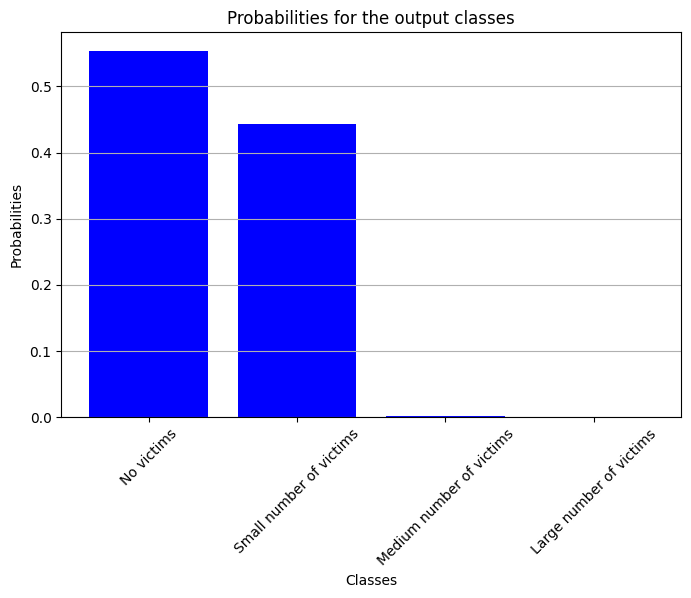

True Class Label: No victims


In [366]:
import matplotlib.pyplot as plt

# Store misclassified examples
misclassified_examples = []

# Iterate through the test dataset
for i, (x_test, y_test) in enumerate(test_loader):
    # Forward pass to get output
    output = model(x_test)

    # Get predictions from the maximum value
    _, predicted = torch.max(output, 1)

    # Convert y_test to a numpy array for comparison
    #Use AI from this part.
    true_labels = y_test.numpy()

    # Check for misclassification
    misclassified_mask = predicted != true_labels #if predicted different true_label so it's misclassified

    misclassified_indices = np.where(misclassified_mask)[0]

    for j in misclassified_indices:
        # Calculate class probabilities
        class_probabilities = torch.nn.functional.softmax(output, dim=1).detach().numpy()[j]

        # Append the misclassified example's information
        misclassified_examples.append((x_test[j], true_labels[j], predicted[j], class_probabilities))

# Select a random misclassified example
index = np.random.randint(0, len(misclassified_examples))
example, true_label, predicted_label, class_probabilities = misclassified_examples[index]

# Define class labels
class_labels = ["No victims", "Small number of victims", "Medium number of victims", "Large number of victims"]

# Plot the class probabilities in a bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_labels, class_probabilities, color='b')
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Probabilities for the output classes')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Print the true class label
print(f"True Class Label: {class_labels[true_label]}")



In this example, the model's predictions shows some uncertainty, with a probability of around 55% assigned to the "No victims" class and 44% to the "Small number of victims" class, while the true class is "No victims." The model's confidence in its prediction is relatively low, hesitating between the first two classes.




## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


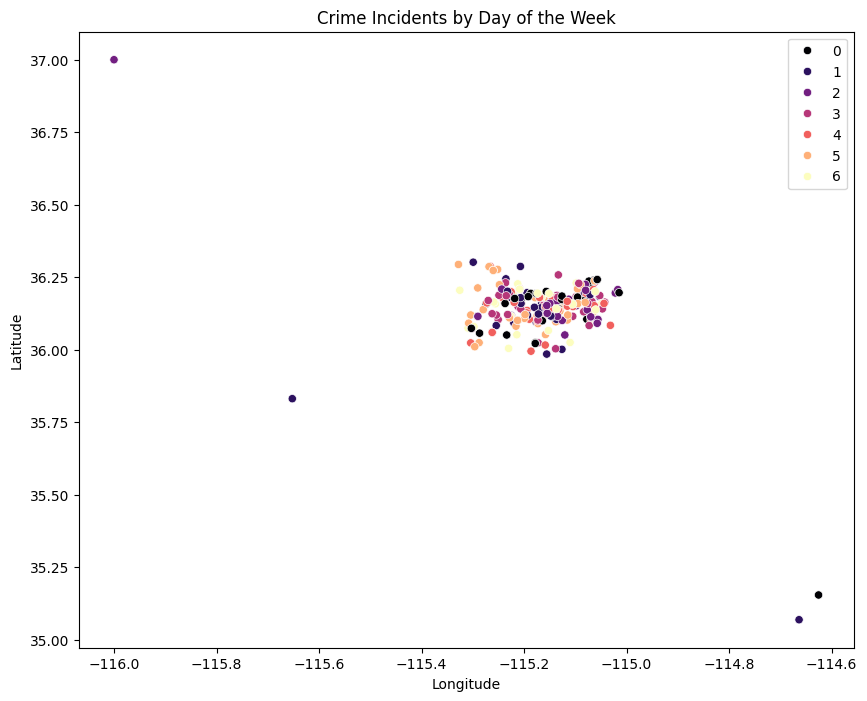

In [375]:
# Define a color palette to represent the number of persons involved
colors = sns.color_palette("magma", as_cmap=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette=colors)


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Incidents by Day of the Week')
plt.legend()
plt.show()


We can't see a pattern is this plot. We have a cluster where every points is gathered together but we cannot separate the colors.

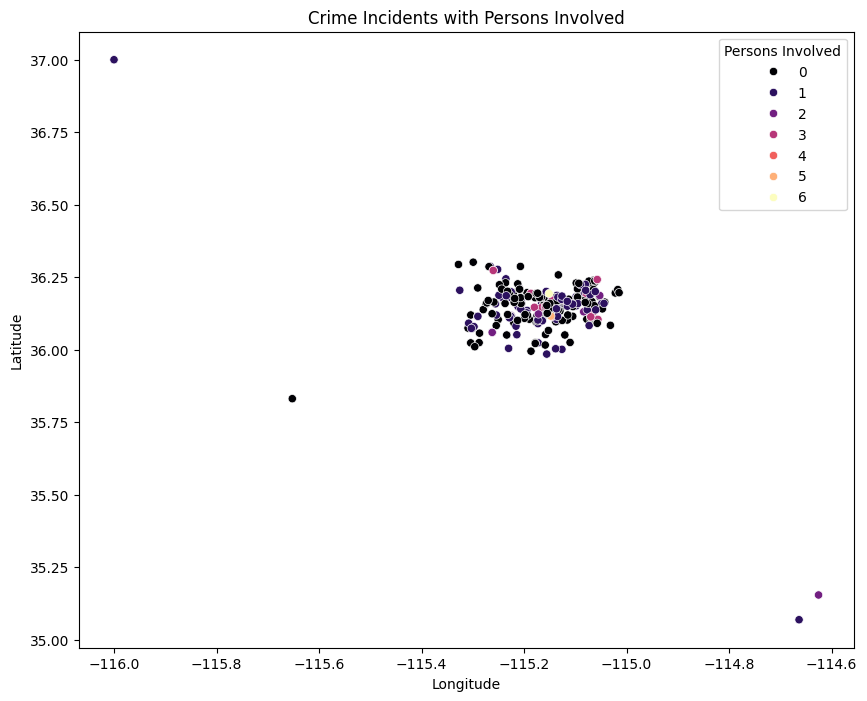

In [377]:
# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='VictimCount', palette=colors)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crime Incidents with Persons Involved')

# Show the color bar (legend)
plt.legend(title='Persons Involved')

# Show the plot
plt.show()

We still, with a slight difference, have the same graphic than before with the days of the week. Some crime areas seem to have 0 victims but this part should be expanded to identify a cluster

In [379]:
#Help by an AI
data = df['DayOfWeek'].to_numpy()

# Count the occurrences of each day
unique_days, counts = np.unique(data, return_counts=True)

# Create a dictionary to store the counts
day_counts = dict(zip(unique_days, counts))

# Sort the days by their frequencies in descending order
sorted_days = sorted(day_counts.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent days
for day, count in sorted_days:
    print(f"{day}: {count} crimes")

4: 51 crimes
3: 44 crimes
5: 43 crimes
0: 40 crimes
1: 37 crimes
2: 32 crimes
6: 28 crimes


The day number 4 is the more frequent.